In [69]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from skopt.plots import plot_convergence, plot_objective
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.feature_selection import f_classif, VarianceThreshold, mutual_info_classif, RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [70]:
df_insurance = pd.read_csv('./insurance.csv')
df_insurance = df_insurance.drop_duplicates()

In [71]:
def print_missing_columns(df) :
    # show me only the columns with missing values and the percentage
    # if the % of the missing values is height we may drop the column
    # missing values not numeric all enum types

    missing_values_count = df.isnull().sum()
    missing_percentage = (missing_values_count / len(df)) * 100

    missing_data_summary = pd.DataFrame({
        'Missing Count': missing_values_count,
        'Missing % Total': missing_percentage
    })

    missing_data_summary = missing_data_summary[missing_data_summary['Missing Count'] > 0]

    print(missing_data_summary)

In [72]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict, key_model):
    return {key.replace(key_model,'') :  value for key, value in dict.items()}

In [73]:
def plot_histogram(df, col_name: str):
    import matplotlib.pyplot as plt
    import seaborn as sns

    df_copy = df.copy()
    median_val = df_copy[col_name].median()

    axis_format = plt.FuncFormatter(lambda x, loc: f"{int(x):,}")
    axis_format_prcnt = plt.FuncFormatter(lambda x, loc: f"{x:,.1%}")

    fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

    hist = sns.histplot(df_copy[col_name], kde=True, ax=axes[0])
    hist.get_yaxis().set_major_formatter(axis_format)
    hist.axvline(median_val, linewidth = 4, linestyle ="--",
                color ='black')
    hist.set_title(f"Median '{col_name}' is {median_val:,}");

    ecd = sns.ecdfplot(df_copy[col_name], ax=axes[1])
    ecd.get_yaxis().set_major_formatter(axis_format_prcnt)
    ecd.set_title(f"Cumulative Distribution of Records by '{col_name}");

    plt.suptitle(f"Distribution of Records by '{col_name}'", size=16);
    plt.show();

In [74]:
def train_test_split_model():
    y = df_insurance['insurance_cost_binary']
    X = df_insurance.drop('insurance_cost_binary', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

    return X_train, X_test, y_train, y_test

In [75]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1
mean_fpr = np.linspace(start=0, stop=1, num=100)

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    y_score = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, thresholds = roc_curve(y_test, y_score)

    fig, ax = plt.subplots(1, 4, figsize=(20, 6))

    plot_tpr_and_fpr_vs_threshold(ax[0], thresholds, _tpr, _fpr)
    plot_precision_vs_threshold(ax[1] , y_test, y_score)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
    plot_roc_curve(ax[2] , _auc, _tpr, _fpr)

    y_pred = (y_score >= 0.6).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax[3])

    for text in disp.text_.ravel():
        text.set_color('red')  # Set text color to red (or any color, e.g., 'white', 'black')

    plt.show()

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [76]:
from sklearn.metrics import precision_recall_curve

# recall  - ( get them all even if you grab extra )
# precision - actually picked (all about accuracy - only pick red )

def plot_precision_vs_threshold(axis , y_test, y_score) :
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_score)
    axis.plot(pr_thresholds, precision[:-1], label='Precision', color='green', lw=2)
    axis.plot(pr_thresholds, recall[:-1], label='Recall (TPR)', color='blue', lw=2)
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('Classification Threshold')
    axis.set_ylabel('Metric Value')
    axis.set_title('Precision and Recall vs. Classification Threshold')
    axis.legend(loc='best')
    axis.grid(True)

In [77]:
# tpr catch as many bad things (recall)
# fpr - how often you mess up good things

def plot_tpr_and_fpr_vs_threshold(axis , thresholds, tpr, fpr) :
    axis.plot(thresholds, tpr, label='TPR', lw=2)
    axis.plot(thresholds, fpr, label='FPR', lw=2)
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('Threshold')
    axis.set_ylabel('Rate')
    axis.set_title('TPR and FPR vs. Threshold')
    axis.legend(loc='best')
    axis.grid(True)

In [78]:
def plot_roc_curve(axis , auc, tpr, fpr) :
    axis.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    axis.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title('Receiver Operating Characteristic (ROC) Curve')
    axis.legend(loc='lower right')
    axis.grid(True)

In [79]:
def iqr_technique_percentage(data, column):
    """ Calculate the outlier % for the column """

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)

    outliers = data[(data[column] < lower_range) | (data[column] > upper_range)]

    return (len(outliers)/len(data))*100

In [80]:
def print_outliers(df):

    numeric_df_column_names = df.select_dtypes(include=['number']).columns.tolist()

    for index, column_name in enumerate(numeric_df_column_names, start=1):
        target_column = df[column_name]
        print(f" outliers {column_name} - {iqr_technique_percentage(df, column_name)} % out of total")

In [81]:
def print_results(search, X_train, y_train, X_test, y_test) :
    best_model = search.best_estimator_
    best_model.fit(X_train, y_train)

    print("Best parameters: ", search.best_params_)

    print("Best CV score = %0.3f:" % search.best_score_)
    print("Training score = %0.3f:" % best_model.score(X_train, y_train))
    print("Test score = %0.3f:" % best_model.score(X_test, y_test))

    # If training score >> CV score, focus on regularization.
    # If metrics reveal poor performance on minority classes, address imbalance

    # Poor performance on minority classes often manifests as low precision, recall, or F1-score for those classes
    y_pred = best_model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Balanced Accuracy (test):\n", balanced_accuracy_score(y_test, y_pred))

    # Plot the convergence of the search process - this plot is linked to the "n_iter"
    plot_convergence(search.optimizer_results_[0])

In [82]:
df_insurance

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075
...,...,...,...,...,...,...,...
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240


In [83]:
def condition(df_insurance, median_value):
    if df_insurance['insurance_cost'] <= median_value:
        return 0
    else:
        return 1

median_value = df_insurance['insurance_cost'].median()
print(median_value)

# create a new column
df_insurance['insurance_cost_binary'] =  df_insurance.apply(lambda row: condition(row, median_value), axis=1)

# drop the column
df_insurance = df_insurance.drop(columns=['insurance_cost'])

print_missing_columns(df_insurance)
print_outliers(df_insurance)

9386.1613
Empty DataFrame
Columns: [Missing Count, Missing % Total]
Index: []
 outliers age - 0.0 % out of total
 outliers bmi - 0.6731488406881078 % out of total
 outliers children - 0.0 % out of total
 outliers insurance_cost_binary - 0.0 % out of total


In [84]:
df_insurance['insurance_cost_binary'].value_counts()

insurance_cost_binary
0    669
1    668
Name: count, dtype: int64

In [85]:
df_insurance.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

,age,bmi,children,insurance_cost_binary
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,0.499626
std,14.044333,6.100468,1.205571,0.500187
min,18.000000,15.960000,0.000000,0.000000
25%,27.000000,26.290000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,0.000000
75%,51.000000,34.700000,2.000000,1.000000
max,64.000000,53.130000,5.000000,1.000000


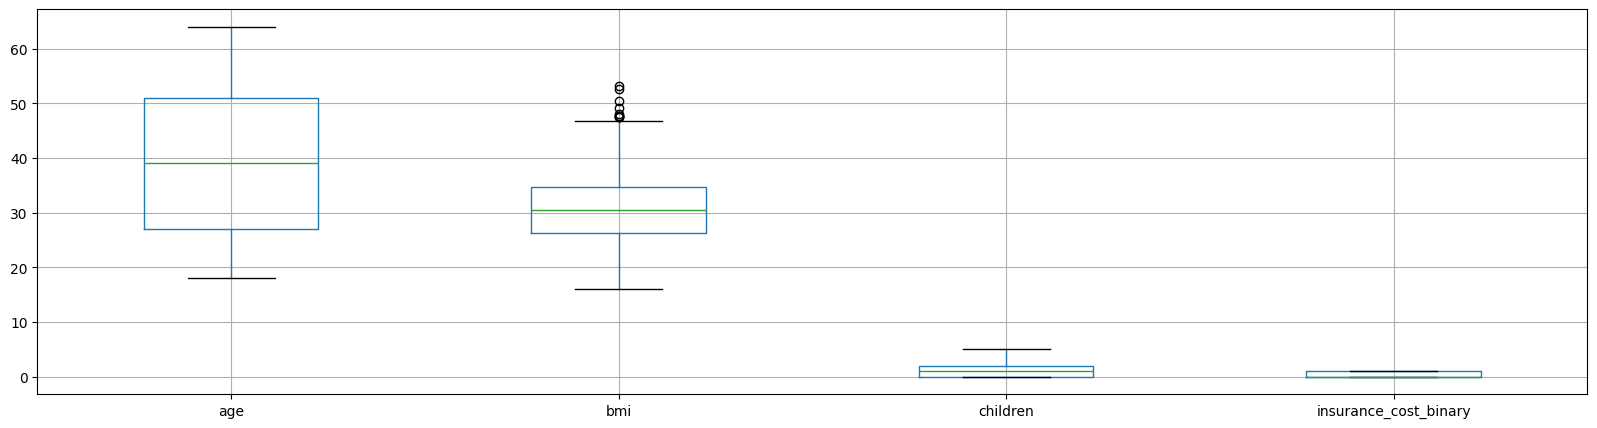

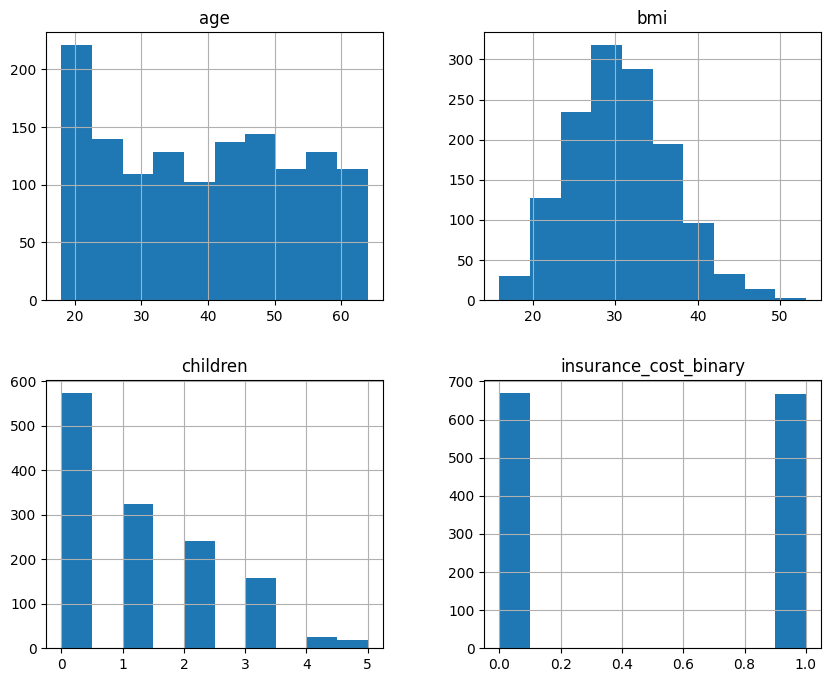

In [86]:
df_insurance.boxplot(figsize=(20,5))
df_insurance.hist(bins=10, figsize=(10, 8))
df_insurance.describe()

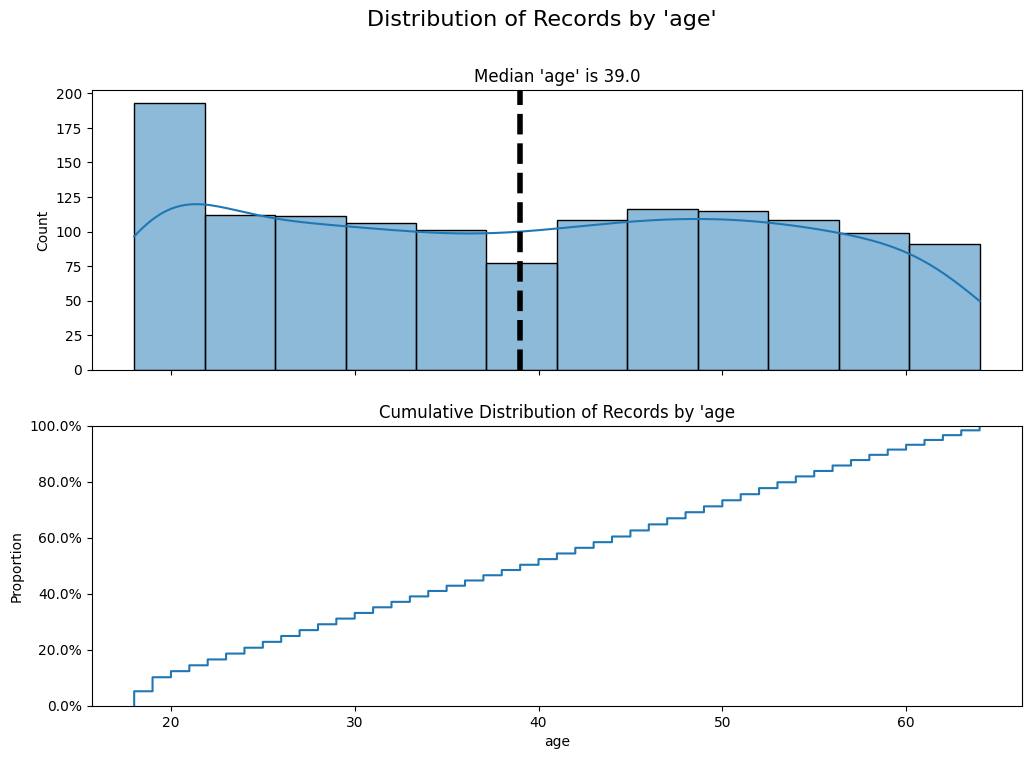

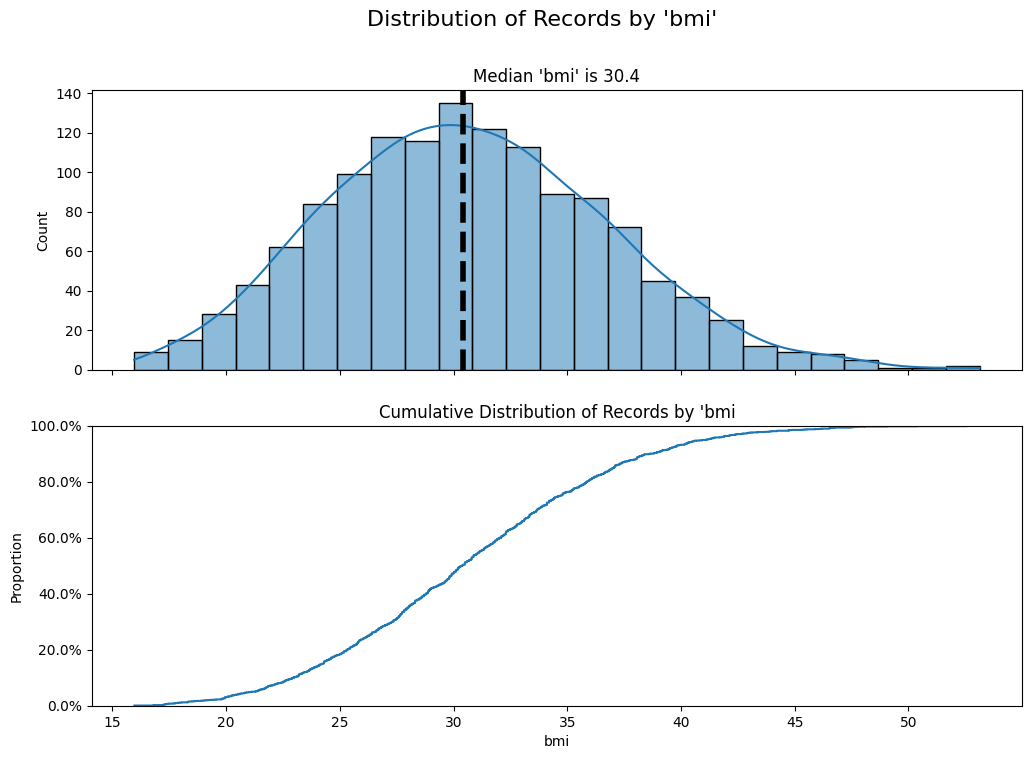

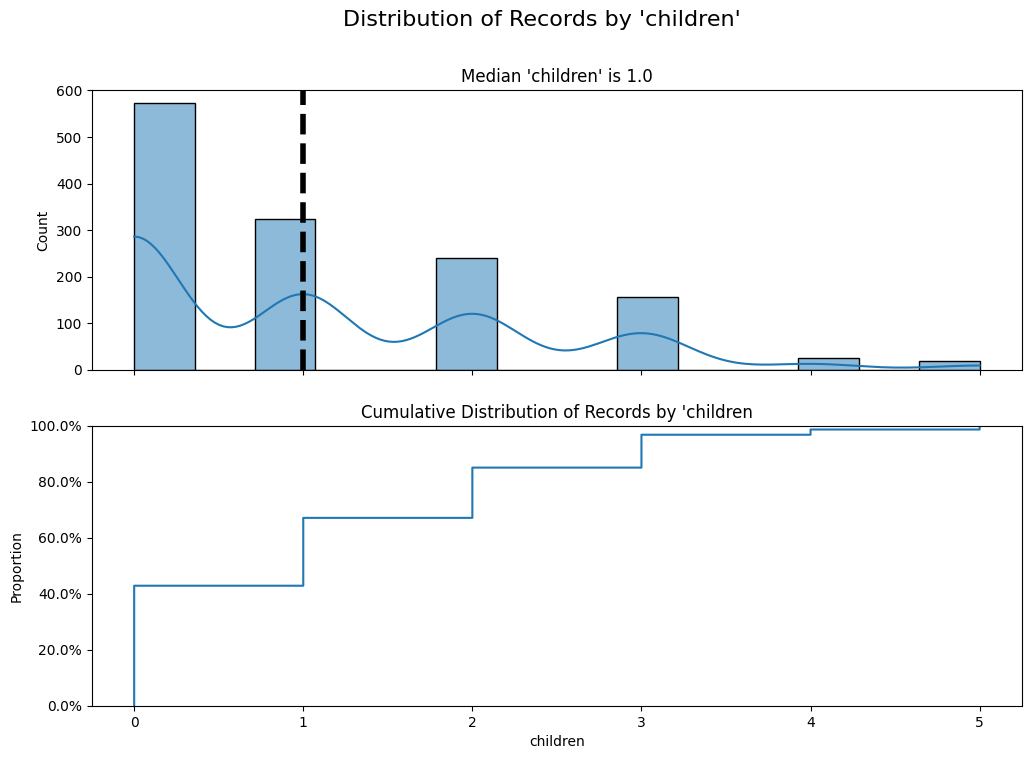

In [87]:
plot_histogram(df_insurance, 'age')
plot_histogram(df_insurance, 'bmi')
plot_histogram(df_insurance, 'children')

In [88]:
columns_no_outliers = ['age']

In [89]:
columns_outliers_no_zeros = ['bmi'];

In [90]:
columns_outliers_and_zeros = ['children'];

In [91]:
columns_category = ['gender', 'smoker', 'region']

In [92]:
outliers_no_zeros_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)),
        ("scaler", RobustScaler())
    ], memory='cache_folder'
)

outliers_and_zeros_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ],  memory='cache_folder'
)

columns_category_pipline = Pipeline(
    steps = [
        ("category_encode", OrdinalEncoder()), # OneHotEncoding messing it up result
        ("scaler", MinMaxScaler())
    ], memory='cache_folder'
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("outliers_no_zeros", outliers_no_zeros_pipeline, columns_outliers_no_zeros),
        ("outliers_and_zeros", outliers_and_zeros_pipeline, columns_outliers_and_zeros),
        ("no_outliers", outliers_no_zeros_pipeline, columns_no_outliers),
        ("category_no_order", columns_category_pipline, columns_category)
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

In [93]:
outliers_no_zeros_pipeline_no_scale = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log))
    ], memory='cache_folder'
)

outliers_and_zeros_pipeline_no_scale = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt))
    ],  memory='cache_folder'
)

columns_category_pipline_no_scale = Pipeline(
    steps = [
        ("category_encode", OrdinalEncoder()), # OneHotEncoding messing it up result
    ], memory='cache_folder'
)

preprocess_pipeline_no_scale = ColumnTransformer(
    transformers = [
        ("outliers_no_zeros", outliers_no_zeros_pipeline_no_scale, columns_outliers_no_zeros),
        ("outliers_and_zeros", outliers_and_zeros_pipeline_no_scale, columns_outliers_and_zeros),
        ("no_outliers", outliers_no_zeros_pipeline_no_scale, columns_no_outliers),
        ("category_no_order", columns_category_pipline_no_scale, columns_category)
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

In [94]:
X_train, X_test, y_train, y_test = train_test_split_model()

In [95]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('pca', PCA(random_state=42)),
    ('rfe', RFE(step=0.1, estimator=LogisticRegression(random_state=42))), # impact outcome step
    ('select', SelectKBest(mutual_info_classif)),               # lower class love
    ('svm', svm.SVC(probability=True, class_weight='balanced')) # wanted lower classes to be given same love as upper classes, need probability=True for the report below
], memory='cache_folder')

C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  OrderedDict([('pca__n_components', 4), ('rfe__n_features_to_select', 4), ('select__k', 4), ('svm__C', 100.0), ('svm__gamma', 0.9187298645476241)])
Best CV score = 0.929:
Training score = 0.947:
Test score = 0.914:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       134
           1       0.95      0.87      0.91       134

    accuracy                           0.91       268
   macro avg       0.92      0.91      0.91       268
weighted avg       0.92      0.91      0.91       268

Confusion Matrix:
 [[128   6]
 [ 17 117]]
Balanced Accuracy (test):
 0.914179104477612


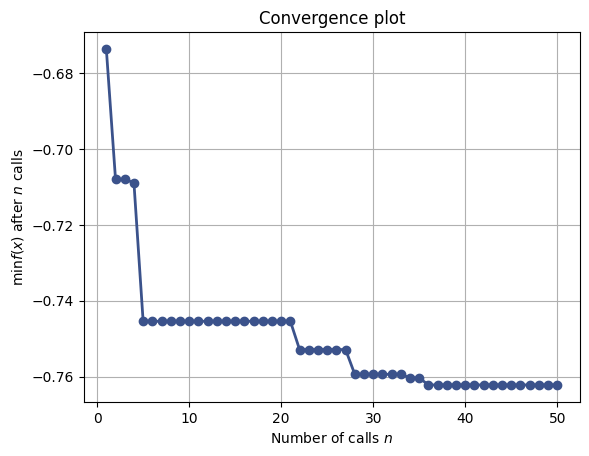

In [96]:
param_grid = [
    {
        'pca__n_components': Categorical([n]),
        'rfe__n_features_to_select': Categorical(list(range(1, n + 1))),      # Number of components
        'select__k': Categorical(list(range(1, n + 1))),                      # k from 1 to n_components
        'svm__C': Real(0.1, 100, 'log-uniform'),
        'svm__gamma': Real(0.001, 100, 'log-uniform') # increased gamma and c as gamma values allways on the top edge
    }
    for n in range(2, min(5, X_train.shape[1] + 1))
]

search = BayesSearchCV(pipe, param_grid, n_points=3, n_iter=50, verbose=0, cv=5, n_jobs=-1, refit=True, scoring='balanced_accuracy', random_state=42)
search.fit(X_train, y_train)

print_results(search, X_train, y_train, X_test, y_test)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

In [97]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline_no_scale),
    ('pca', PCA(random_state=42)), # impacts result
    ('rfe', RFE(estimator=LogisticRegression(random_state=42, max_iter=1000))),
    ('rf', RandomForestClassifier(oob_score=True, random_state=42, class_weight='balanced_subsample'))
], memory='cache_folder')

C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 15, None, 2, 50, 2] before, using random point [2, 6, 'log2', 5, 55, 2]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 13, None, 2, 50, 2] before, using random point [2, 8, 'log2', 3, 53, 1]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 12, 'log2', 2, 100, 3] before, using random point [4, 12, None, 4, 69, 3]
  warnings.warn(
C:\Users\jorgeblx\AppData\

OOB score of best model: 0.9298409728718429
Best parameters:  OrderedDict([('pca__n_components', 4), ('rf__max_depth', 9), ('rf__max_features', 'log2'), ('rf__min_samples_split', 5), ('rf__n_estimators', 100), ('rfe__n_features_to_select', 4)])
Best CV score = 0.930:
Training score = 0.957:
Test score = 0.937:
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       134
           1       0.97      0.90      0.93       134

    accuracy                           0.94       268
   macro avg       0.94      0.94      0.94       268
weighted avg       0.94      0.94      0.94       268

Confusion Matrix:
 [[130   4]
 [ 13 121]]
Balanced Accuracy (test):
 0.9365671641791045


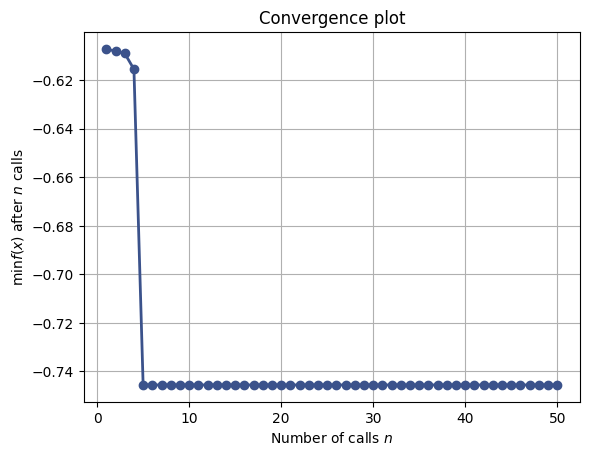

In [98]:
param_grid = [
    {
        'pca__n_components': Categorical([n]),
        'rfe__n_features_to_select': Categorical(list(range(1, n + 1))),      # Number of components
        'rf__n_estimators': Integer(50, 100),     # Number of trees
        'rf__max_depth':Integer(5, 15),          # Maximum depth of trees
        'rf__min_samples_split': Integer(2, 5),   # Minimum samples to split
        'rf__max_features': Categorical(['sqrt', 'log2', None])  # Optimize feature sampling
    }
    for n in range(2, min(5, X_train.shape[1] + 1))
]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = BayesSearchCV(pipe, param_grid, n_points=3, n_iter=50, verbose=0, cv=kfold,
                       n_jobs=-1,
                       refit=True,
                       scoring='balanced_accuracy',
                       random_state=42)
search.fit(X_train, y_train)

print("OOB score of best model:", search.best_estimator_.named_steps['rf'].oob_score_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

# If train > CV/test  -- Overfitting
# If train ≈ CV/test  -- Underfitting
print_results(search, X_train, y_train, X_test, y_test)

In [99]:
from sklearn.ensemble import StackingClassifier

stacking_classifier = StackingClassifier(
    estimators=[
        ('svm', svm.SVC(probability=True, class_weight='balanced')),
        ('rf', RandomForestClassifier(oob_score=True, random_state=42, class_weight='balanced_subsample'))
    ],
    final_estimator=LogisticRegression(),
    cv=5,  # Cross-validation for stacking
    n_jobs=-1  # Parallelize
)

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('stacking', stacking_classifier)
], memory='cache_folder')

C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  OrderedDict([('stacking__rf__max_depth', 8), ('stacking__rf__max_features', 'log2'), ('stacking__rf__min_samples_split', 2), ('stacking__rf__n_estimators', 51), ('stacking__svm__C', 21.06724655001358), ('stacking__svm__gamma', 3.4019124163828165)])
Best CV score = 0.937:
Training score = 0.963:
Test score = 0.922:
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       134
           1       0.94      0.90      0.92       134

    accuracy                           0.92       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.92      0.92      0.92       268

Confusion Matrix:
 [[126   8]
 [ 13 121]]
Balanced Accuracy (test):
 0.9216417910447762


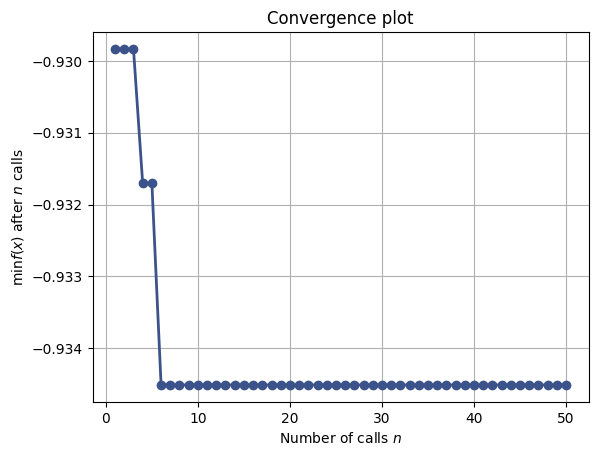

In [100]:
param_grid = [
    {
        'stacking__rf__n_estimators': Integer(50, 100),     # Number of trees
        'stacking__rf__max_depth':Integer(5, 15),          # Maximum depth of trees
        'stacking__rf__min_samples_split': Integer(2, 5),   # Minimum samples to split
        'stacking__rf__max_features': Categorical(['sqrt', 'log2', None]),  # Optimize feature sampling
        'stacking__svm__C': Real(0.1, 300, 'log-uniform'),
        'stacking__svm__gamma': Real(0.001, 300, 'log-uniform') # increased gamma and c as gamma values allways on the top edge
    }
    for n in range(2, min(5,  X_train.shape[1] + 1))
]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = BayesSearchCV(pipe, param_grid, n_points=3, n_iter=50, verbose=0, cv=kfold, n_jobs=-1, refit=True, scoring='accuracy', random_state=42)
search.fit(X_train, y_train)

# store the best params and best model for later use
SC_best_params = search.best_params_
SC_best_model = search.best_estimator_

print_results(search, X_train, y_train, X_test, y_test)

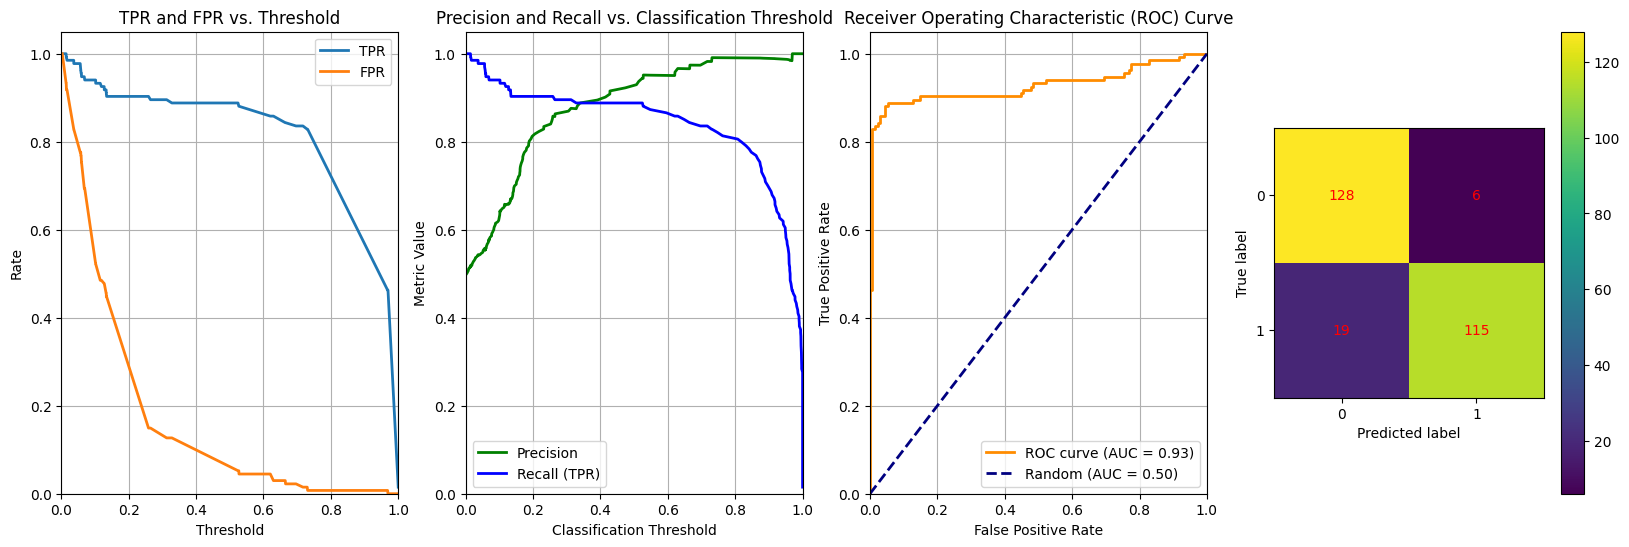

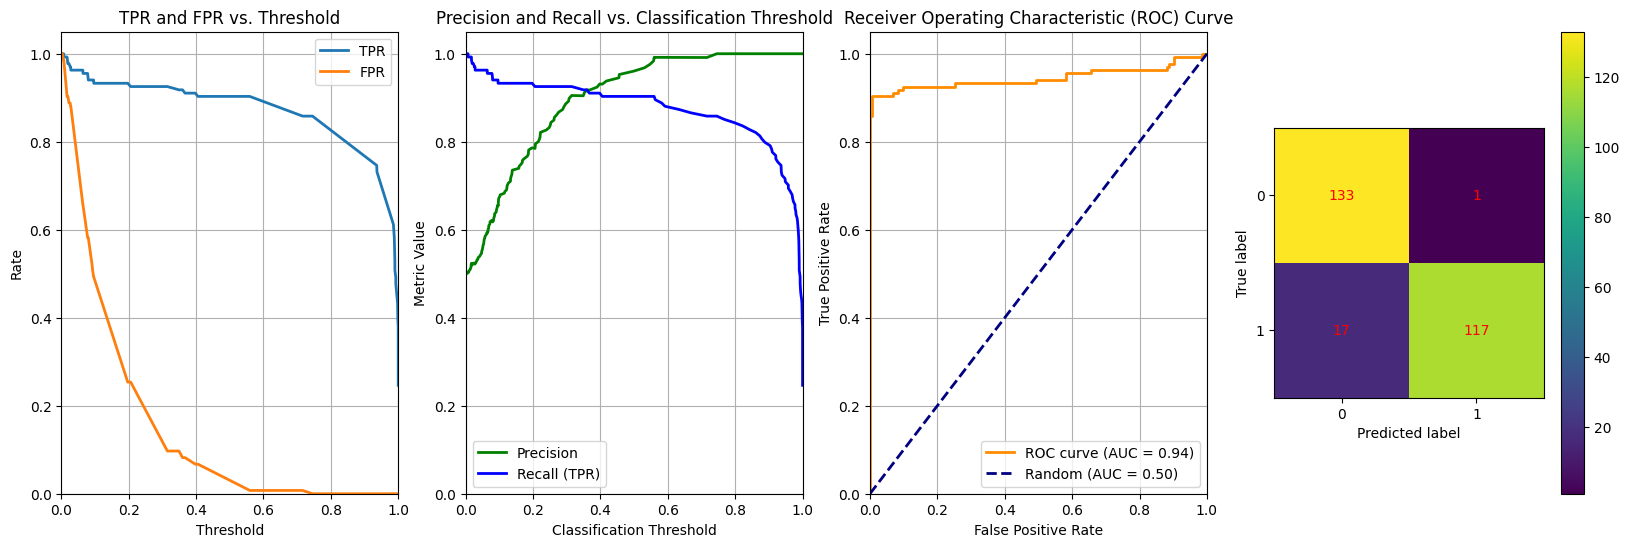

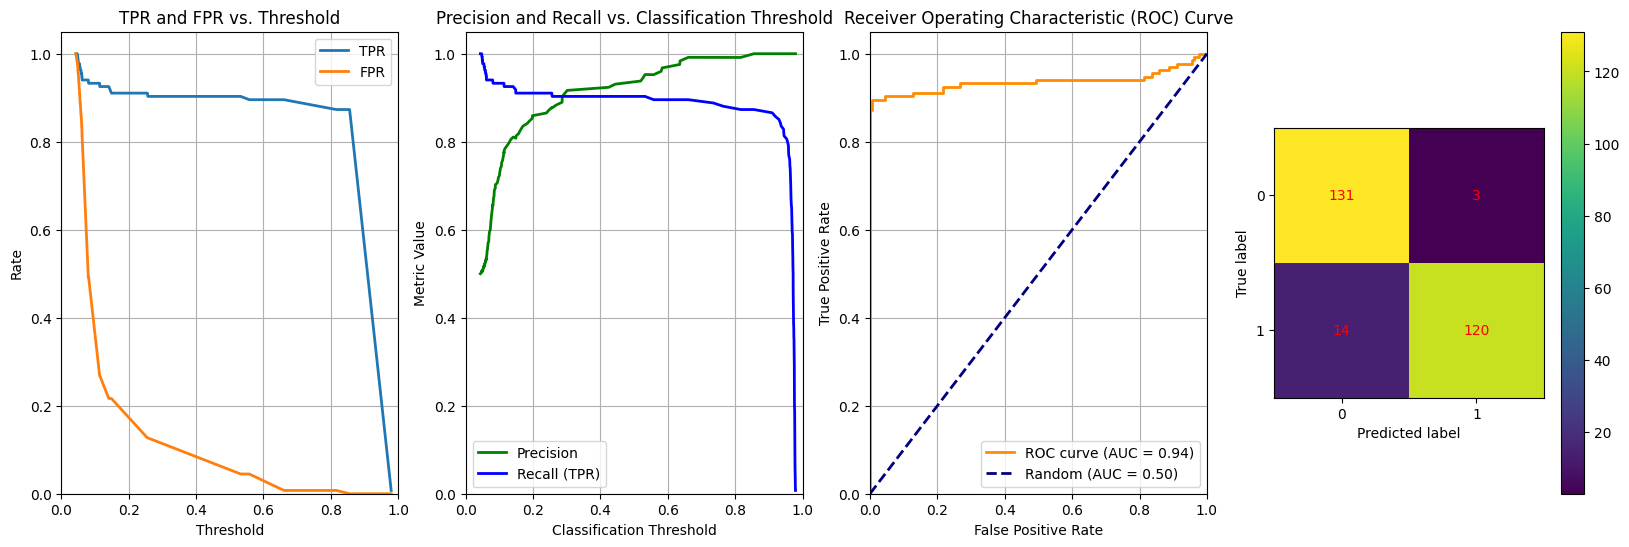

In [101]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
SC_accuracy, SC_precision, SC_recall, SC_f1_score, SC_tpr, SC_auc = evaluate_model(X_test, y_test, SC_best_model)

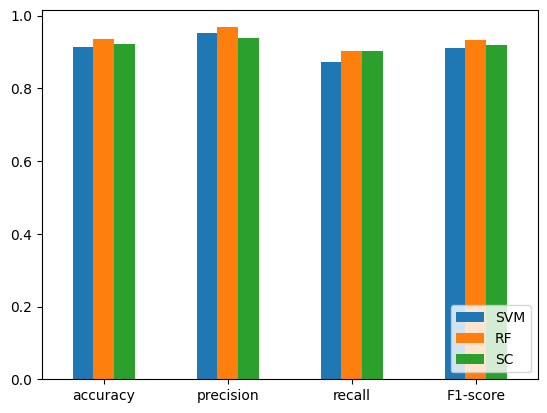

In [102]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
SC_metrics = np.array([SC_accuracy, SC_precision, SC_recall, SC_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'RF': RF_metrics, 'SC': SC_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

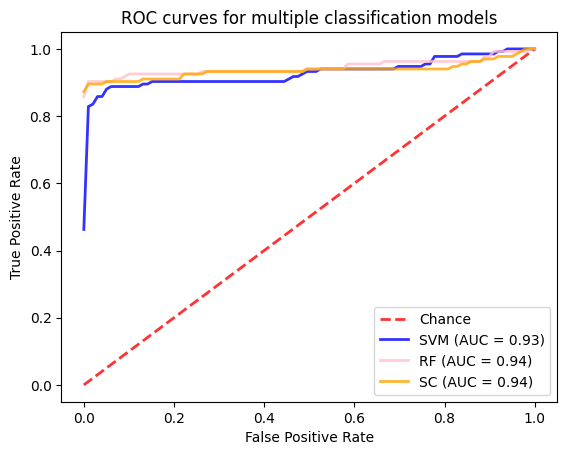

In [103]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='pink', label='RF (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, SC_tpr[0,:], lw=2, color='orange', label='SC (AUC = %0.2f)' % (SC_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

#AUC = 0.5: Random guessing.
#AUC > 0.7: Decent model.
#AUC > 0.9: Excellent model.
#If AUC is low, check if the model overfits or if features need more preprocessing.